In [ ]:
!pip install ray


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 MB 9.9 MB/s eta 0:00:00


2024-11-08 09:57:19,020	INFO worker.py:1816 -- Started a local Ray instance.


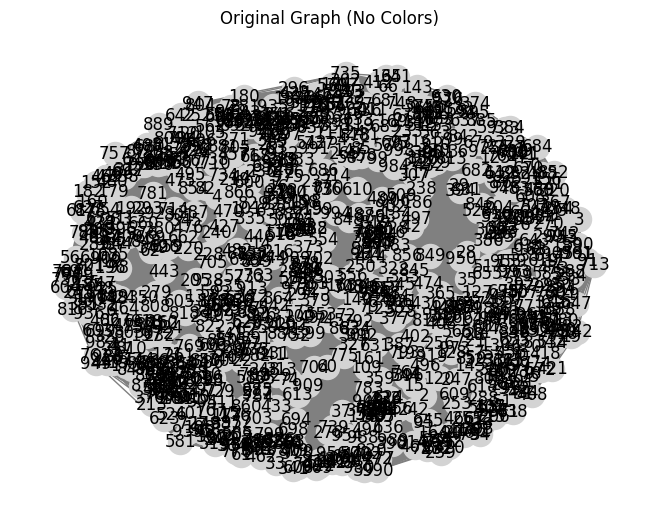

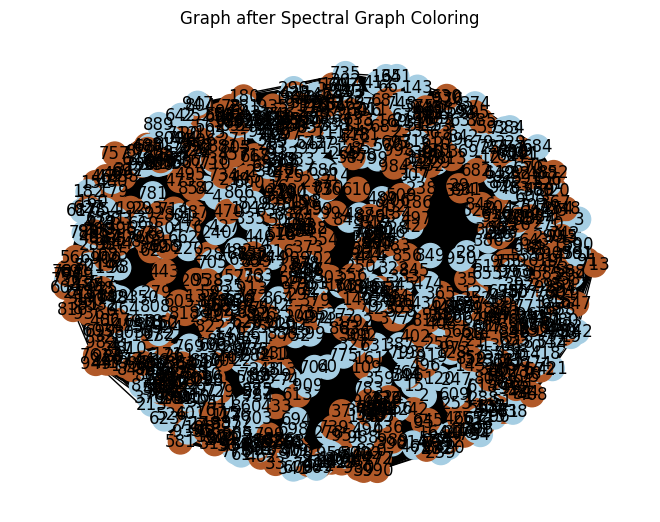

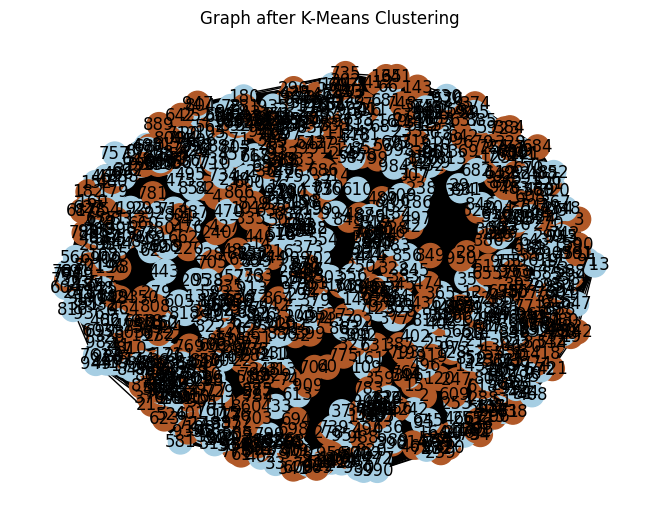

Sequential execution time:  4.3052754402160645
Parallel execution time:  7.1851112842559814


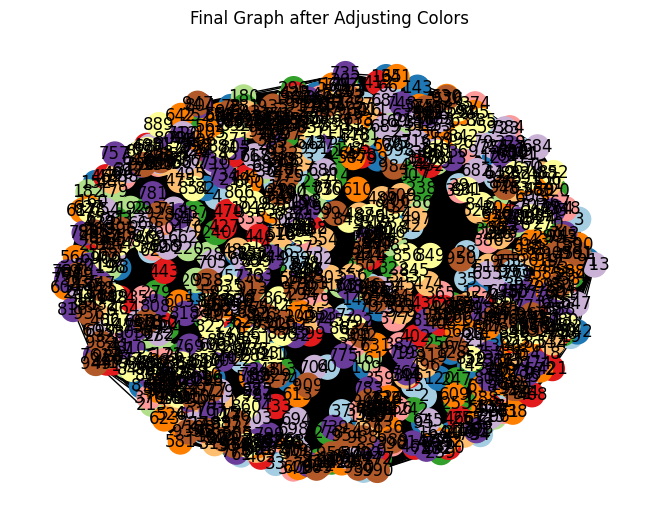

In [ ]:
import numpy as np
import networkx as nx
from scipy.linalg import eigvals
from sklearn.cluster import KMeans
import time
import ray
import os
import matplotlib.pyplot as plt

# Ray initialization
ray.init(num_cpus=2)

# Function to perform spectral graph coloring
def spectral_graph_coloring(graph):
    laplacian_matrix = nx.laplacian_matrix(graph).todense()

    eigenvalues = eigvals(laplacian_matrix)
    sorted_indices = np.argsort(eigenvalues)
    second_smallest_eigenvalue_index = sorted_indices[1]
    eigenvector = np.linalg.eig(laplacian_matrix)[1][:, second_smallest_eigenvalue_index]

    # Assign colors based on the sign of the eigenvector
    colored_vertices = np.sign(eigenvector)

    # Convert colors to integers
    colored_vertices = np.array([int(color) for color in colored_vertices])

    # Count the number of vertices and colors
    num_vertices = len(graph.nodes)
    num_colors = len(set(colored_vertices))
    time.sleep(1)
    return colored_vertices

# Function to parallelize K-Means clustering using Ray
@ray.remote
class KMeansActor:
    def __init__(self, data, num_clusters):
        self.data = data
        self.num_clusters = num_clusters

    def kmeans_clustering(self):
        os.environ['OMP_NUM_THREADS'] = '1'  # Set OMP_NUM_THREADS to 1
        kmeans = KMeans(n_clusters=self.num_clusters, n_init=10)
        # Reset OMP_NUM_THREADS for other parts of the program
        os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())

        return kmeans.fit_predict(self.data)

# Function to parallelize spectral graph coloring using Ray
@ray.remote
class SpectralGraphColoringActor:
    def __init__(self, graph):
        self.graph = graph

    def spectral_graph_coloring(self):
        laplacian_matrix = nx.laplacian_matrix(self.graph).todense()
        eigenvalues = eigvals(laplacian_matrix)
        sorted_indices = np.argsort(eigenvalues)
        second_smallest_eigenvalue_index = sorted_indices[1]
        eigenvector = np.linalg.eig(laplacian_matrix)[1][:, second_smallest_eigenvalue_index]

        # Assign colors based on the sign of the eigenvector
        colored_vertices = np.sign(eigenvector)

        # Convert colors to integers
        colored_vertices = np.array([int(color) for color in colored_vertices])

        return colored_vertices

# Function to visualize the graph with colors and a consistent layout
def visualize_graph(graph, colors, title, pos):
    nx.draw(graph, pos, with_labels=True, node_color=colors, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

# Function to visualize the graph without colors
def visualize_graph_no_colors(graph, title, pos):
    nx.draw(graph, pos, with_labels=True, node_color="lightgrey", edge_color="grey")
    plt.title(title)
    plt.show()

# Main function
def main():
    # Generate a sample graph
    G = nx.erdos_renyi_graph(n=1000, p=0.5)

    # Create a consistent layout for all visualizations
    pos = nx.spring_layout(G, seed=42)

    # Visualize the original graph without colors
    visualize_graph_no_colors(G, "Original Graph (No Colors)", pos)

    # Measure time for sequential spectral graph coloring
    start_time_sequential = time.time()
    result_sequential = spectral_graph_coloring(G)
    end_time_sequential = time.time()

    # Visualize graph after spectral graph coloring
    visualize_graph(G, result_sequential, "Graph after Spectral Graph Coloring", pos)

    # Create the SpectralGraphColoringActor for parallel time calculation
    spectral_actor = SpectralGraphColoringActor.remote(G)

    # Measure time for parallel spectral graph coloring
    start_time_parallel_spectral = time.time()
    result_parallel_spectral = ray.get([spectral_actor.spectral_graph_coloring.remote() for _ in range(2)])
    end_time_parallel_spectral = time.time()

    # Convert colored vertices to array for K-Means clustering
    data_sequential = np.array(result_sequential).reshape(-1, 1)
    data_parallel_spectral = np.array(result_parallel_spectral).reshape(-1, 1)

    # Apply K-Means clustering sequentially
    num_clusters = 2
    start_time_kmeans_sequential = time.time()
    time.sleep(1)
    os.environ['OMP_NUM_THREADS'] = '1'
    kmeans_result_sequential = KMeans(n_clusters=num_clusters, n_init=10).fit_predict(data_sequential)
    end_time_kmeans_sequential = time.time()
    # Reset OMP_NUM_THREADS for other parts of the program
    os.environ["OMP_NUM_THREADS"] = str(os.cpu_count())

    # Visualize graph after K-means clustering
    visualize_graph(G, kmeans_result_sequential, "Graph after K-Means Clustering", pos)

    # Create KMeansActor for parallel time calculation
    kmeans_actor = KMeansActor.remote(data_parallel_spectral, num_clusters)

    # Measure time for parallel K-Means clustering using Ray
    start_time_kmeans_parallel = time.time()
    kmeans_result_parallel = ray.get([kmeans_actor.kmeans_clustering.remote() for _ in range(2)])
    end_time_kmeans_parallel = time.time()

    print("Sequential execution time: ", end_time_kmeans_sequential - start_time_kmeans_sequential + end_time_sequential - start_time_sequential)
    print("Parallel execution time: ", end_time_kmeans_parallel - start_time_kmeans_parallel + end_time_parallel_spectral - start_time_parallel_spectral)

    # Shutdown Ray
    ray.shutdown()

    # Combine results for final colored vertices
    colored_vertices_final = np.concatenate([result_sequential, *result_parallel_spectral, kmeans_result_sequential, *kmeans_result_parallel])

    # Create a colored graph
    colored_graph = G.copy()
    for node, color in zip(G.nodes, colored_vertices_final):
        colored_graph.nodes[node]['color'] = color

    # Assign new colors to adjacent nodes if they have the same color
    for node in colored_graph.nodes:
        neighbors = list(colored_graph.neighbors(node))
        node_color = colored_graph.nodes[node]['color']
        neighbor_colors = set(colored_graph.nodes[neighbor]['color'] for neighbor in neighbors)
        if node_color in neighbor_colors:
            new_color = max(neighbor_colors) + 1
            colored_graph.nodes[node]['color'] = new_color

    # Visualize the final colored graph
    final_colors = [colored_graph.nodes[node]['color'] for node in colored_graph.nodes]
    visualize_graph(colored_graph, final_colors, "Final Graph after Adjusting Colors", pos)

if __name__ == "__main__":
    main()